In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
import cv2
import json
import numpy as np
import joblib
from datetime import timedelta

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix


In [2]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.y = y.copy()
        self.x = x.copy()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        sample = self.x[idx]
        sample_y = self.y[idx]
        return torch.tensor(sample).float(), torch.tensor(sample_y).float()

In [3]:
def time_to_seconds(time_str):
    """Преобразует строку формата MM:SS в количество секунд"""
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

def extract_frames(video_path, time_intervals, target_resolution, frame_rate):
    """Извлекает кадры из видеофайла в указанных временных промежутках и сохраняет их с указанной меткой"""
    cap = cv2.VideoCapture(video_path)
    frames = []
    labels = []
    for start_time, end_time in time_intervals:
        start_frame = int(frame_rate * start_time)
        end_frame = int(frame_rate * end_time)
        l = (end_frame - start_frame) // 2
        real_start_frame = start_frame
        if start_frame - l > 0:
            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame-l)
            current_frame = start_frame-l
            start_frame = start_frame-l
        else:
            cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
            current_frame = 0
            start_frame = 0
        current_frame = start_frame
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        real_end_frame = end_frame
        if end_frame + l < total_frames:
            end_frame = end_frame + l
        else:
            end_frame = total_frames
        while cap.isOpened() and current_frame <= end_frame:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, target_resolution)
            frames.append(frame / 255)
            if current_frame > real_start_frame and current_frame < real_end_frame:
                labels.append(1)
            else:
                labels.append(0)
            current_frame += 1
    frames = np.array(frames).astype(np.float32)
    #frames = np.array_split(frames, ((end_frame-start_frame)//10)+1)
    labels = np.array(labels)
    #labels = np.array_split(labels, ((end_frame-start_frame)//10)+1)
    cap.release()
    return frames, labels

def prepare_dataset(video_dir, annotation_file, target_resolution, violation_type):
    """Готовит набор данных на основе видеофайлов и разметки"""
    with open(annotation_file, 'r', encoding='utf-8') as f:
        annotations = json.load(f)
    videos = []
    all_lables = []
    for annotation in tqdm(annotations):
        video_name = annotation['name']
        start_time = time_to_seconds(annotation['start'])
        end_time = time_to_seconds(annotation['end'])
        violation = annotation['type']

        video_path = os.path.join(video_dir, video_name)
        frame_rate = cv2.VideoCapture(video_path).get(cv2.CAP_PROP_FPS)

        if violation_type == violation:
            frames, lables = extract_frames(video_path, [(start_time, end_time)],target_resolution, frame_rate)
            videos.extend(frames)
            all_lables.extend(lables)
    videos = np.array(videos)
    all_lables = np.array(all_lables)
    return videos, all_lables

video_dir = '../data/train'

# Путь к файлу разметки
annotation_file = '../data/train/разметка.json'
output_path = "../data/подлезание/"

# Путь к папке, куда будут сохранены последовательности
violation_type = "Подлезание под вагоны стоящего состава"
target_resolution = (50, 50)

# Подготовка данных
X, y = prepare_dataset(video_dir, annotation_file, target_resolution, violation_type)


  0%|          | 0/34 [00:00<?, ?it/s]

100%|██████████| 34/34 [00:41<00:00,  1.22s/it]


In [4]:
l = len(X) // 10

In [5]:
X = np.array_split(X, l)
len(X)

798

In [6]:
max_length = max(len(section) for section in X)
X = [i for i in X if len(i)!=max_length]
len(X)

791

In [7]:
y = np.array_split(y, l)
len(y)

798

In [8]:
max_length = max(len(section) for section in y)
y = [i for i in y if len(i)!=max_length]
len(y)

791

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [11]:
data, label = next(iter(train_loader))

In [12]:
data.shape

torch.Size([10, 10, 50, 50, 3])

In [13]:
label.shape

torch.Size([10, 10])

In [14]:
class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__()
        self.flatten = nn.Flatten()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.lstm = nn.LSTM(64 * 144, 128, batch_first=True)
        self.fc = nn.Linear(128, 10)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, seq_length, w, h, c = x.size()
        c_in = x.view(batch_size * seq_length, c, h, w)
        #c_in = self.flatten(c_in)
        c_out = self.cnn(c_in)
        c_out = c_out.view(batch_size, seq_length, -1)
        lstm_out, _ = self.lstm(c_out)
        lstm_out = lstm_out[:, -1, :]
        fc_out = self.fc(lstm_out)
        out = self.sigmoid(fc_out)
        return out

model = CNNLSTM()


In [15]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): Сколько эпох ждать после последнего улучшения метрики
            verbose (bool): Выводить сообщения о каждой проверке (по умолчанию False)
            delta (float): Минимальное изменение для улучшения метрики
            path (str): Путь для сохранения модели
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Сохранение модели, если валидационная потеря уменьшилась'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


Epoch 43, Validation Loss: 0.252855, Accuracy: 0.6000


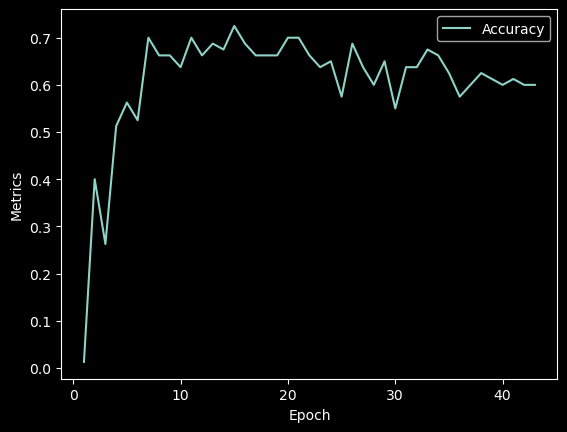

EarlyStopping counter: 30 out of 30
Early stopping


In [17]:
# Инициализация модели, функции потерь и оптимизатора
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Параметры ранней остановки
early_stopping = EarlyStopping(patience=30, verbose=True)

# Цикл обучения
# Lists to store metrics for plotting
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

num_epochs = 1000
for epoch in range(num_epochs):
    # Training
    model.train()
    size = len(train_dataset)
    i = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        i+=1

        if i % 100 == 0:
            loss, current = loss.item(), i * len(data)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

    # Validation
    model.eval()
    val_loss = 0
    predictions = []
    targets = []
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            predictions.extend([x > 0.5 for x in output.cpu().numpy()])
            targets.extend([x > 0.5 for x in target.cpu().numpy()])

        val_loss = val_loss / len(val_loader)

        # Calculate metrics
        #predictions = [x > 0.5 for x in predictions]
        #targets = [x > 0.5 for x in targets]
        accuracy = accuracy_score(targets, predictions)
        #precision = precision_score(targets, predictions)
        #recall = recall_score(targets, predictions)
        #f1 = f1_score(targets, predictions)

        # Append metrics to lists for plotting
        accuracy_list.append(accuracy)
        #precision_list.append(precision)
        #recall_list.append(recall)
        #f1_list.append(f1)
        clear_output()
        #print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.6f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
        print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.6f}, Accuracy: {accuracy:.4f}')

    # Plotting
    #conf_matrix = confusion_matrix(targets, predictions)
    #print("Confusion Matrix:")
    #print(conf_matrix)
    plt.figure()
    plt.plot(range(1, epoch+2), accuracy_list, label='Accuracy')
    #plt.plot(range(1, epoch+2), precision_list, label='Precision')
    #plt.plot(range(1, epoch+2), recall_list, label='Recall')
    #plt.plot(range(1, epoch+2), f1_list, label='F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.legend()
    plt.show()

    # Early stopping condition
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

In [33]:
with torch.no_grad():
    data, target = next(iter(val_loader))
    data, target = data.cpu(), target.cpu()
    model = model.cpu()
    output = model(data)

In [18]:
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

In [19]:
import numpy as np

def get_timestamps(predictions, threshold=0.3, frame_rate=30, window_size=1):
    """
    Получение таймкодов нарушений на основе предсказаний модели.

    predictions: np.array, форма [seq_length]
        Предсказанные вероятности наличия нарушения для каждого окна кадров.
    threshold: float
        Пороговое значение для определения нарушения.
    frame_rate: int
        Количество кадров в секунду.
    window_size: int
        Количество кадров в одном окне.

    Возвращает список кортежей (start_time, end_time) для каждого обнаруженного нарушения.
    """
    timestamps = []
    in_violation = False
    start_time = None

    for i, prob in enumerate(predictions):
        if prob >= threshold and not in_violation:
            in_violation = True
            start_time = i * window_size / frame_rate
        elif prob < threshold and in_violation:
            in_violation = False
            end_time = (i + 1) * window_size / frame_rate
            timestamps.append((start_time, end_time))

    # Если нарушение продолжается до конца видео
    if in_violation:
        end_time = len(predictions) * window_size / frame_rate
        timestamps.append((start_time, end_time))

    return timestamps

# Пример предсказаний (для упрощения, генерируем случайные данные)
predictions = np.random.rand(10)  # 10 окон кадров
predictions[2:4] = 0.7  # Пример нарушения
predictions[7:8] = 0.8  # Пример нарушения

# Получение таймкодов нарушений
timestamps = get_timestamps(predictions, threshold=0.5, frame_rate=30, window_size=1)
print(timestamps)  # Ожидаемый выход: [(start_time, end_time), ...]


[(0.06666666666666667, 0.23333333333333334), (0.23333333333333334, 0.3)]


In [20]:
def seconds_to_time(total_seconds):
    minutes = int(total_seconds // 60)
    seconds = int(total_seconds % 60)
    return '{:02d}:{:02d}'.format(minutes, seconds)

In [35]:
test_dir = "../data/test_dataset"
video_names = os.listdir(test_dir)
video_names = [name for name in video_names if str.lower(name).endswith("mp4")]
out_df = []
for name in video_names:
    out_df_item = {}
    out_df_item["video_name"] = name
    out_df_item["violation_timestamp"] = []
    video_path = os.path.join(test_dir, name)
    cap = cv2.VideoCapture(video_path)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    frames = []
    outputs = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (50,50))
        frames.append(frame / 255)
        frames.append(frame)

    cap.release()

                # Convert the frames list into a numpy array
    video_array = np.array(frames)
    l = len(video_array) // 10
    vid = []
    pred = []
    # Batch processing frames
    batch_size = 10
    for i in range(0, l, batch_size):
        batch_frames = video_array[i:i+batch_size]
        if len(batch_frames) < batch_size:
            batch_frames.extend([np.zeros_like(video_array[0]) for _ in range(batch_size - len(batch_frames))])
        vid.append([batch_frames])

    # Process batches using torch in parallel
    with torch.no_grad():
        for batch in tqdm(vid):
            inp = torch.tensor(batch).float().cpu()
            out = model(inp)
            pred.extend(out.cpu().detach()[0])

    # Process predictions
    predictions = get_timestamps(torch.tensor(pred), frame_rate=frame_rate, window_size=int(frame_rate))
    for item in predictions:
        out_df_item["violation_timestamp"].append(seconds_to_time(item[0]))
    out_df.append(out_df_item)

100%|██████████| 540/540 [00:23<00:00, 22.70it/s]


In [27]:
import pandas as pd

In [28]:
out_df = pd.DataFrame(out_df)


In [29]:
out_df.to_csv("submit.csv", index=False, sep=";")